In [2]:
import sys
import os
sys.path.append("../src/whole_history_rating")
from whr import whole_history_rating
from whr import utils
from datetime import datetime
import datetime as dt
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

This uses the default main branch of whr. e.g. it will use "black/white" to refer to the winner. "White" is second. 

In [3]:
data_path = '../data/cfbd/games_1869_to_2020.csv'

In [55]:
games_df = pd.read_csv(data_path)
games_df = games_df[games_df.season>2010]
games_df.shape

(8332, 25)

win_prob with 2.5 home field =  1/(1+10^(2.5/13))
win_prob with 400 elo scale =  1/(1+10^(x/400))

elo handicap for 2.5 points = 2.5/13 * 400 = 77

In [56]:
datetime_from_cfbd = lambda x: datetime.strptime(x,"%Y-%m-%dT%H:%M:%S.%fZ")

In [57]:
scale = 16
w2 = 50
w2_short_term = 5
whr = whole_history_rating.Base({'scale': scale,'w2':w2,'w2_short_term':w2_short_term,'debug':False})

In [58]:
start_time = 0
home_team_handicap = 2.5/13*scale
verbose = False
for i,row in games_df.iterrows():
    game_time = datetime_from_cfbd(row.start_date)
    if start_time == 0: start_time = game_time
    days = (game_time-start_time).days
    home_team = row.home_team
    away_team = row.away_team
    handicap = -(1-row.neutral_site)*home_team_handicap
    mov = row.home_points-row.away_points
        
    if verbose: print("away team: {}, home team: {}".format(away_team,home_team))
    if verbose: print("winner: {} (W is home), days: {} handicap: {}".format(winner,days,handicap))
    whr.create_game(away_team,home_team,row.away_points,row.home_points, days, handicap)
    #if len(whr.games) > 100: break

In [59]:
len(whr.games)

8332

In [60]:
whr.iterate(10)

timing:

100 games: 0.21831806499903905

1000:      4.505260759000521

8332:      15.015844893998292

23179:     58.9916944889992

74781:     241.91250731699984

77239:     

In [61]:
start_perf_timer = time.perf_counter()
whr.auto_iterate(time_limit = 10, precision = 10E-3*scale/400)
end_perf_timer = time.perf_counter()
end_perf_timer-start_perf_timer

13.63079295299758

In [62]:
def get_player_history(player_name,start_time=0, seasons=[]):
    ratings = whr.ratings_for_player(player_name)
    if start_time:
        ratings = [[dt.timedelta(days=d)+start_time,elo,unc] for d,elo,unc in ratings]
    return ratings

In [63]:
players = [
           'Texas A&M',
           'Ohio State',
           'Alabama',
           'Clemson',
           #'Minnesota',
           'LSU',
           #'Vanderbilt',
           #'Florida State',
           #'Harvard',
           #'Yale',
           #'Princeton'
           #'UAB',
           #'North Dakota State',
          ]

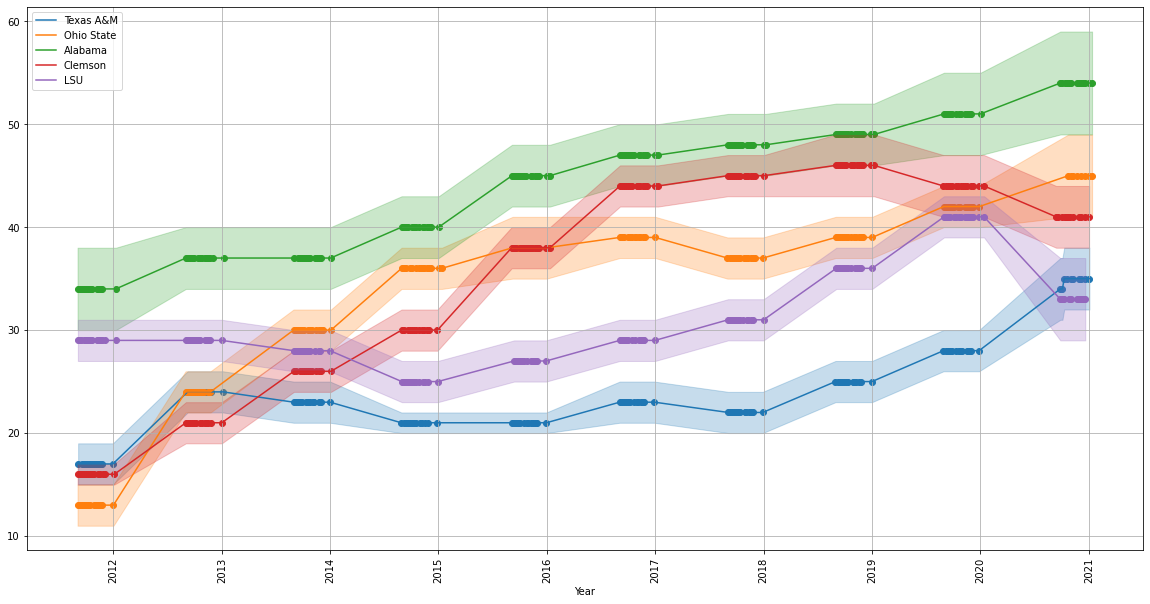

In [64]:
fig = plt.figure(figsize=[20,10])
for player in players:
    player_details = get_player_history(player,start_time=start_time)
    dates,ratings,uncertainties = list(zip(*player_details))
    ratings,uncertainties = np.asarray(ratings),np.asarray(uncertainties)
    line_plot = plt.plot(dates,ratings,label=player)
    color = line_plot[0].get_color()
    plt.scatter(dates,ratings,color=color)
    up,down = ratings+uncertainties, ratings-uncertainties
    plt.fill_between(dates,up,down, alpha=.25,color=color)
    
    
years = mdates.YearLocator()
years_fmt = mdates.DateFormatter('%Y')

ax = fig.axes[0]
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.grid(True)
#fig.autofmt_xdate()

#plt.ylim((-40,80))
plt.xticks(rotation=90)
plt.legend()
plt.xlabel('Year')
plt.savefig('scale_{}_w_{}.pdf'.format(scale,w2))


In [ ]:
whr.print_ordered_ratings(current=True)

In [ ]:
whr.save_base("mov_first_draft_whr_base.pkl")